The protein links file is too large to be uploaded to the contents folder directly, so you will need to use the following code to unzip the compressed version. Go on the folder icon on the left toolbar, and open the content folder and drop the txt.gz in there along with the 9606.protein.info.v12.0.txt file (which is unzipped already for you). You can download the files [here](https://drive.google.com/drive/folders/1HxXp18n4foMmkuLyP3Ea_5QAa2VP2_sr?usp=sharing).

**Please note that it will take about a minute for the files to be uploaded to this notebook after you click the upload button**

In [ ]:
import gzip
import shutil

# Input and output file paths
input_info = '/content/9606.protein.links.full.v12.0.txt.gz'
output_info = '/content/9606.protein.links.full.v12.0.txt'


# Decompress the file
with gzip.open(input_info, 'rb') as f_in:
    with open(output_info, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Decompressed {input_info} to {output_info}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/9606.protein.links.full.v12.0.txt.gz'

# **Node2Vec Walkthrough on Protein-Protein Interaction Network**
# Introduction
In this walkthrough, we will explore how to use **node2vec** to generate embeddings for a Protein-Protein Interaction (PPI) network. By representing proteins as nodes and their interactions as edges in a graph, we can apply graph embedding techniques to capture the complex relationships between proteins.

Node2Vec is an algorithm to generate vector representations of nodes in a graph, by simulating biased random walks and applying the Skip-Gram model from word2vec.


**1. Import Libraries**



In [ ]:
pip install node2vec

In [ ]:
# Graph handling
import networkx as nx

# Numerical computations
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Node2Vec implementation
from node2vec import Node2Vec

# Dimensionality reduction and machine learning
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


#**Load the Dataset**

**About the Dataset**

Our subset will be the Human Protein-Protein Interaction network from the STRING database. STRING consists of known and predicted protein-protein associations for a large number of organisms.

Each node represents a protein, and an edge represents an interaction between two proteins. Proteins are also annotated with functional categories (e.g., biological processes), which we'll use for a node classification task.

**Downloading the Dataset**


You can download the files [here](https://drive.google.com/drive/folders/1HxXp18n4foMmkuLyP3Ea_5QAa2VP2_sr?usp=sharing).


In [ ]:

# Load Interaction Data (9606.protein.links.full.v12.0.txt)
links_file = "9606.protein.links.full.v12.0.txt"


# Load interaction data, filtering only necessary columns
edges = pd.read_csv(links_file, sep=" ", usecols=["protein1", "protein2", "combined_score"])

# Filter high-confidence interactions (e.g., combined_score > 700)
edges = edges[edges["combined_score"] > 700]

print("Edges loaded:")
print(edges.head())

# Create an undirected graph
G = nx.Graph()

# Add edges with weights
for _, row in edges.iterrows():
    G.add_edge(row["protein1"], row["protein2"], weight=row["combined_score"])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Load Node Metadata (9606.protein.info.v12.0.txt)
info_file = "9606.protein.info.v12.0.txt"

# Load node metadata
node_info = pd.read_csv(info_file, sep="\t")

# Map metadata to graph nodes
for _, row in node_info.iterrows():
    if row["#string_protein_id"] in G:
        G.nodes[row["#string_protein_id"]]["preferred_name"] = row["preferred_name"]
        G.nodes[row["#string_protein_id"]]["annotation"] = row["annotation"]


# Example: Access metadata for a specific node
example_node = list(G.nodes)[0]
print(f"Protein ID: {example_node}")
print(f"Name: {G.nodes[example_node].get('name')}")
print(f"Annotation: {G.nodes[example_node].get('annotation')}")




Edges loaded:
                 protein1              protein2  combined_score
85   9606.ENSP00000000233  9606.ENSP00000158762             825
130  9606.ENSP00000000233  9606.ENSP00000357048             718
160  9606.ENSP00000000233  9606.ENSP00000262305             952
197  9606.ENSP00000000233  9606.ENSP00000329419             752
268  9606.ENSP00000000233  9606.ENSP00000469035             795
Graph has 16185 nodes and 236000 edges
Protein ID: 9606.ENSP00000000233
Name: None
Annotation: ADP-ribosylation factor 5; GTP-binding protein involved in protein trafficking; may modulate vesicle budding and uncoating within the Golgi apparatus. Belongs to the small GTPase superfamily. Arf family.


Understanding the basic properties of the graph can provide insights into its structure.

**Degree Distribution**:
The degree of a node is the number of edges connected to it. In a PPI network, this represents how many interactions a protein has with other proteins.

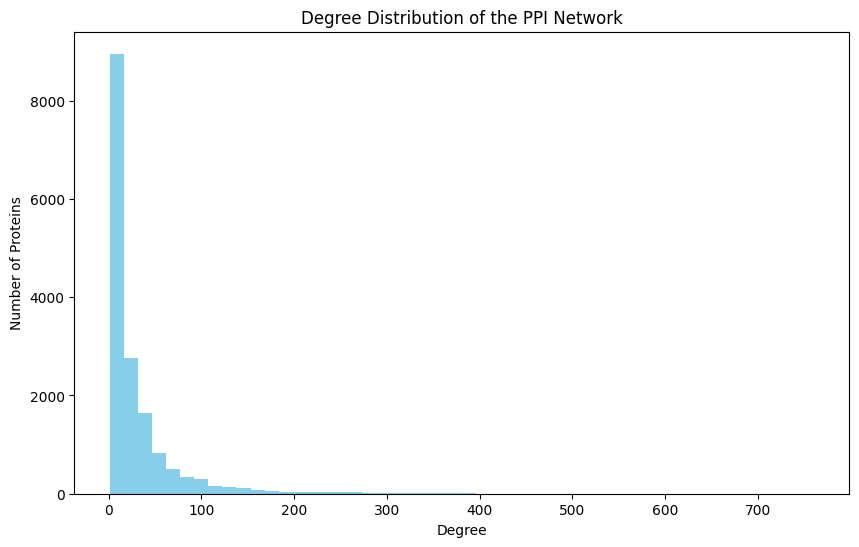

Is the PPI network connected? False
Number of proteins after extracting largest connected component: 15867


In [ ]:
# Compute degrees
degrees = [G.degree(n) for n in G.nodes()]

# Plot degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='skyblue')
plt.title('Degree Distribution of the PPI Network')
plt.xlabel('Degree')
plt.ylabel('Number of Proteins')
plt.show()

# Check if the graph is connected
is_connected = nx.is_connected(G)
print(f"Is the PPI network connected? {is_connected}")

if not is_connected:
    # Extract the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()
    print(f"Number of proteins after extracting largest connected component: {G.number_of_nodes()}")


Graph Visualization
Due to the size of the graph, visualizing the entire network might be cluttered. Let's visualize a subgraph.

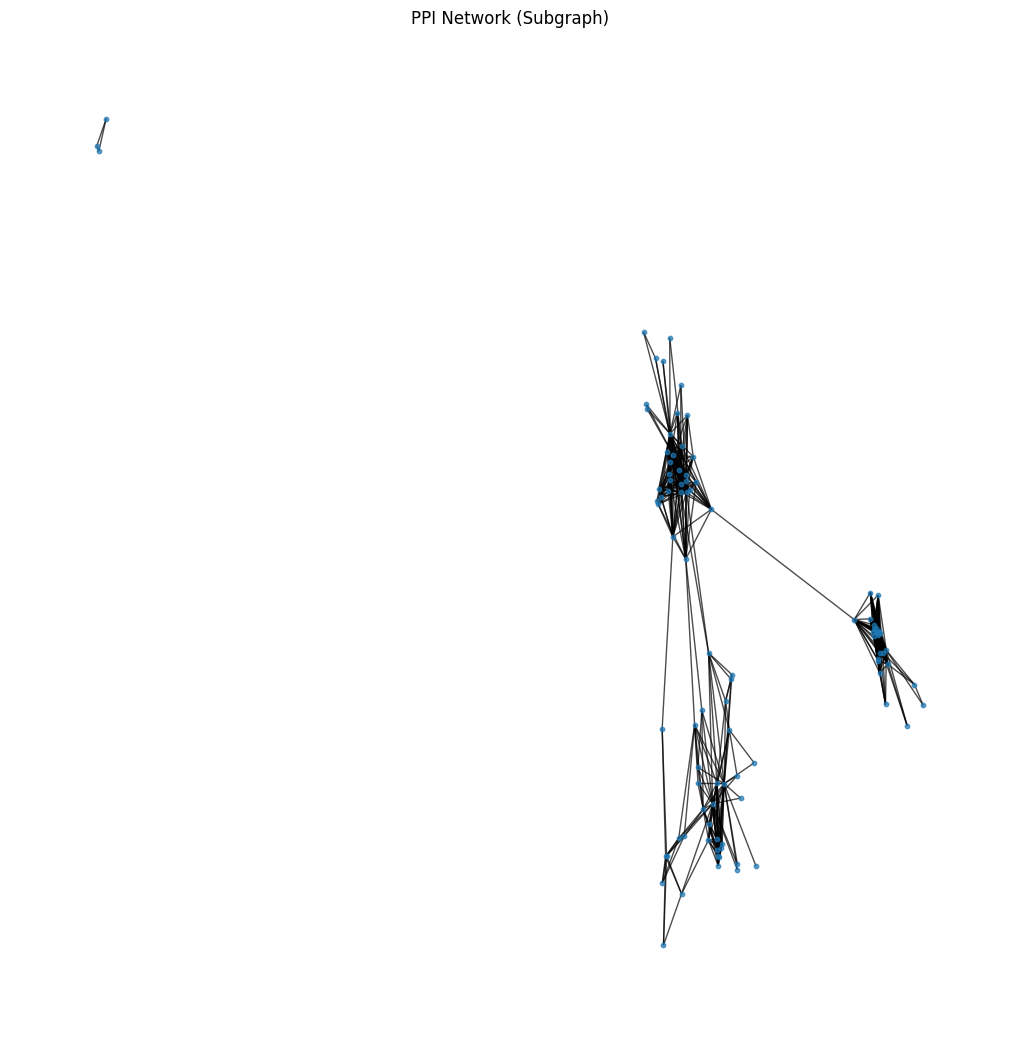

In [ ]:
# Visualize a Small Subgraph
# Extract a subgraph of the first 100 nodes
subgraph = G.subgraph(list(G.nodes())[:100])

# Visualize the subgraph
plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=False, node_size=10, alpha=0.7)
plt.title("PPI Network (Subgraph)")
plt.show()


Now, we'll generate embeddings for each protein using node2vec.

**Setting Up Node2Vec**

**dimensions:** The number of dimensions of the embeddings.

**walk_length**: The length of each random walk.

**num_walks:** The number of walks per node.

**p and q:** Return and in-out parameters controlling the walk strategy.

In [ ]:
# Instantiate Node2Vec change num_walks from 50 to 10 and walk_length from 30 to 10 to make it run faster
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=10, workers=16, p=1, q=1)


Computing transition probabilities:   0%|          | 0/15867 [00:00<?, ?it/s]

#Generate Embeddings
**Node2Vec Model Fitting**

The Node2Vec model is a method for learning embeddings of graph nodes. These embeddings capture the structural and semantic relationships between nodes. The embeddings are learned using random walks and a skip-gram model similar to Word2Vec.

`model = node2vec.fit(window=10, min_count=1, batch_words=4)`

**Key Parameters:**

`window=10:` The context window size for the skip-gram model. This specifies how far from the current node the model should consider neighbors when generating embeddings.

For example, if the window size is 10, the model will consider nodes up to 10 steps away during training.

`min_count=1:` Minimum frequency of a node to be included in the vocabulary. A value of 1 ensures that all nodes are included.

batch_words=4: Number of words (nodes in this case) processed in each batch during training.
Skip-Gram Objective Function:
The skip-gram model optimizes embeddings by maximizing the probability of observing a node’s neighbors within the context window. Mathematically, the objective function is:

$L = \sum_{u \in V} \sum_{v \in N_u} \log P(v \mid u)$

Where

𝑉 is the set of all nodes in the graph.

$N_u$ represents the neighbors of node 𝑢 within the context window.

$P(v∣u)$ is the probability of observing node 𝑣 given node 𝑢 defined using softmax:

$$
P(v \mid u) = \frac{\exp(\vec{z}_u \cdot \vec{z}_v)}{\sum_{w \in V} \exp(\vec{z}_u \cdot \vec{z}_w)}
$$
Here, $z_u$ and $z_v$ are the embeddings for nodes $u$ and $v$.

The Node2Vec model refines this objective by sampling random walks and introducing biases (via return and in-out parameters) to balance between breadth-first and depth-first exploration.



In [ ]:
# Fit the model
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Create a mapping of protein IDs to embeddings
embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
protein_ids = list(G.nodes())


We'll reduce the dimensionality of the embeddings to 2D using t-SNE for visualization.

In [ ]:
# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Extract annotations from graph nodes
node_annotations = {node: data.get("annotation", "Unknown") for node, data in G.nodes(data=True)}

# Map unique annotations to integers
unique_annotations = list(set(node_annotations.values()))
annotation_to_int = {annotation: idx for idx, annotation in enumerate(unique_annotations)}
# Assign integer targets to nodes
node_targets = [annotation_to_int.get(node_annotations.get(node, "Unknown"), -1) for node in G.nodes()]

# Filter out nodes without valid annotations
known_indices = [i for i, x in enumerate(node_targets) if x != -1]
embeddings_2d_known = embeddings_2d[known_indices]
node_targets_known = [node_targets[i] for i in known_indices]


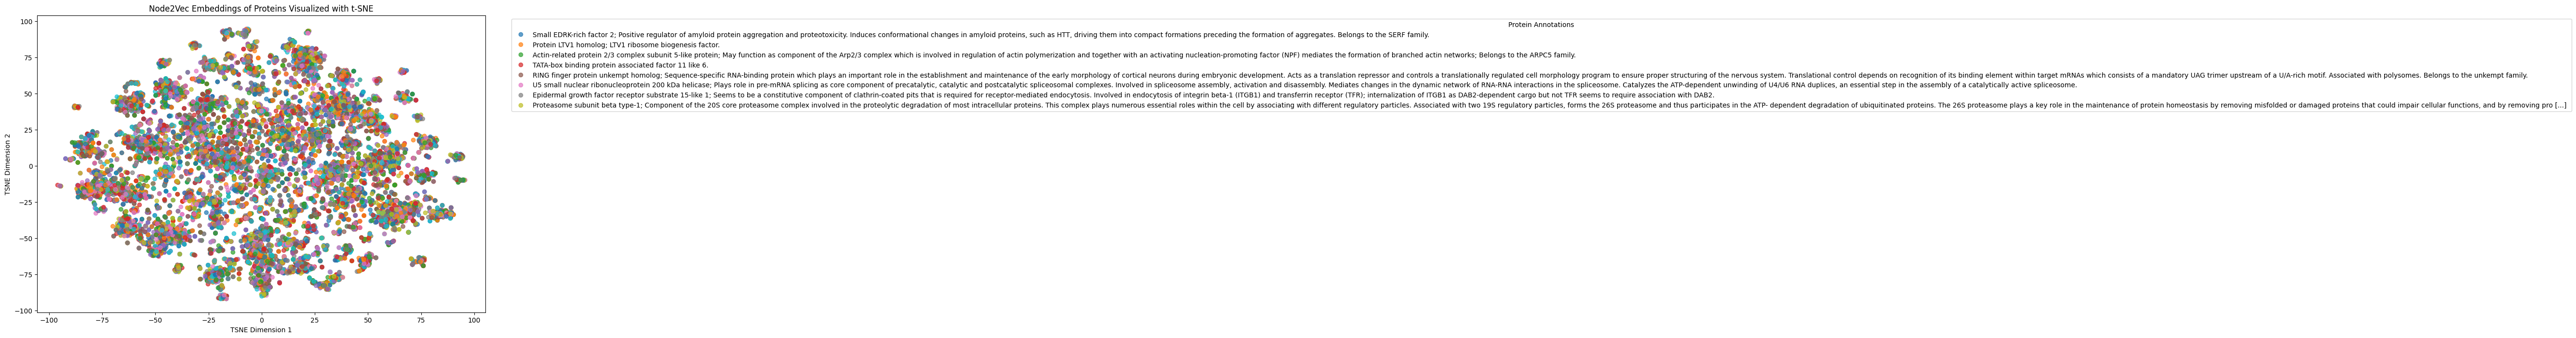

In [ ]:
# Create a reverse mapping from integers back to annotations for legend labels
int_to_annotation = {idx: annotation for annotation, idx in annotation_to_int.items()}

# Plot the embeddings
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d_known[:, 0],
    embeddings_2d_known[:, 1],
    c=node_targets_known,
    cmap='tab10',
    alpha=0.7
)

# Add legend using the annotation labels
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[int_to_annotation[i] for i in range(len(int_to_annotation))],
    title='Protein Annotations',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Add titles and labels
plt.title('Node2Vec Embeddings of Proteins Visualized with t-SNE')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.show()


Interpretation: Proteins with similar functions may cluster together in the embedding space.

# Protein Function Prediction

Using the embeddings as features, we'll train a classifier to predict the functional category of proteins.



In [ ]:
# Prepare Data
# Feature matrix X and label vector y
X = embeddings[known_indices]
y = [node_targets[i] for i in known_indices]


# Get the unique classes and their counts
unique_classes, class_counts = np.unique(y, return_counts=True)

# Identify classes with only one sample
classes_to_remove = unique_classes[class_counts == 1]

# Filter out data points belonging to these classes
mask = ~np.isin(y, classes_to_remove)  # Create a mask for elements to keep
X = X[mask]
y = [element for i, element in enumerate(y) if mask[i]] # Apply mask to keep desired elements


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)



# Train Classifier

# Initialize Logistic Regression model
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

# Train the model
clf.fit(X_train, y_train)


# Evaluate Model

# Predict labels for test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")


# Reverse mapping from integers to annotations for classification report
int_to_annotation = {idx: annotation for annotation, idx in annotation_to_int.items()}

# Generate target names for the classification report
target_names = [int_to_annotation[i] for i in sorted(int_to_annotation.keys())]

# Get the unique classes present in y_train
unique_classes_in_y_train = np.unique(y_train)

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=target_names, labels=unique_classes_in_y_train)
print("\nClassification Report:\n")
print(report)


Test set accuracy: 0.6333

Classification Report:

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                                   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 13, does not match size of target_names, 15807
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this b

**Interpretation:** The accuracy indicates how well the embeddings capture functional similarities among proteins.

# Conclusion
## **What We Did**

**Loaded and Explored the PPI Network:** We analyzed the structure and properties of the protein-protein interaction network.
Generated Node Embeddings: Using node2vec, we created vector representations for each protein in the network.

**Visualized Embeddings:** Applied t-SNE to reduce dimensions and visualized the embeddings, observing clusters of proteins with similar functions.

**Predicted Protein Functions:** Trained a classifier to predict protein functions based on their embeddings.

## **Key Takeaways**

**Graph Embeddings Capture Biological Relationships:** Node embeddings can reflect functional similarities between proteins, which is valuable for bioinformatics analyses.

**Node2Vec is Effective for Biological Networks:** The ability to adjust the random walk parameters allows node2vec to capture diverse structural features in biological graphs.

## **Next Steps**

**Experiment with Node2Vec Parameters:** Adjust p and q to see how they affect the embeddings and classification performance.

**Incorporate Node Attributes:** Use additional biological data (e.g., gene expression levels) to enhance the embeddings.

**Apply to Other Biological Networks:** Extend the approach to gene regulatory networks, metabolic pathways, or disease networks.



**Node2Vec Parameters Explained**

**Return Parameter (p):** Controls the likelihood of revisiting a node in the walk. Higher values discourage backtracking.

**In-Out Parameter (q):** Allows the walk to explore outward nodes (q > 1) or stay close to the starting node (q < 1).
By tuning these parameters, node2vec can balance between:

**Breadth-First Search (BFS):** Captures homophily (nodes with similar roles).

**Depth-First Search (DFS):** Captures structural equivalence (nodes with similar structures).


# Conceptual Questions

1. Explain how Node2Vec works.
2. How might the quality of the input data affect the embeddings?
3. How can Node2Vec embeddings be utilized to predict unknown protein functions or interactions?
4. How does Node2Vec balance between BFS (breadth-first search) and DFS (depth-first search) during random walks?